# **SetUp**

In [1]:
!nvidia-smi

# **ZO**

实验层级配置

L0 Baseline（默认）
- `BATCHDIFF_CKPT = -1`
- 按 `SAVE_STEPS` 固定频率保存**完整 checkpoint**

L1 Batch Differential Checkpoint
- `BATCHDIFF_CKPT = 0`：Log-based（从 base 开始累积所有 updates）
- `BATCHDIFF_CKPT = 1`：Pure Differential（只保存当前 step 的 update）
- `BATCHDIFF_CKPT = N (N >= 2)`：Batch Differential（每 `N` 步生成一次新的 full checkpoint）
对于 batch_size >= 2 (Batch Differential 模式):

save_full_model=False (默认):

每 N 步：更新 base_checkpoint_state（内存），清空 update_history
只保存 batch_diff_meta.pt 和 zo_replay_history.json（空的）
不保存 model.safetensors 或 pytorch_model.bin
恢复时从初始缓存模型开始，replay 所有差分 checkpoint
save_full_model=True:

每 N 步：更新 base_checkpoint_state（内存），清空 update_history
保存 batch_diff_meta.pt、zo_replay_history.json 和完整的模型文件
恢复时可以从最近的完整 checkpoint 开始，减少 replay 的步数

L2 CPU Shadow
- `ENABLE_SHADOW = 1`
- 依赖：`BATCHDIFF_CKPT >= 0`
- CPU 端实时维护 **shadow model**

L3 即时恢复
- `INSTANT_RECOVER = 1`
- 依赖：`L2 + GPU_FAIL_STEP`
- 故障后立即恢复

GPU 故障注入（旁路）
- `GPU_FAIL_STEP = N`
- 在第 `N` 步模拟 GPU 故障
- 可单独使用

In [ ]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_staging_8 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=1 DO_EVAL=0 \
    BATCHDIFF_CKPT=-1 \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 1
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: 0 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: 
Extra args:  --batchdiff_ckpt 0 --no_eval 
2026-02-23 00:32:18,855 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=0,
batchdiff_replay_device=cpu,
batchdiff_resume=,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloade

In [1]:
# diff
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_staging_8 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=1 DO_EVAL=0 \
    BATCHDIFF_CKPT=0 \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 1
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: 0 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: 
BATCHDIFF_REPLAY_DEVICE: cpu
Extra args:  --batchdiff_ckpt 0 --no_eval 
2026-02-23 16:33:48,570 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=0,
batchdiff_replay_device=cpu,
batchdiff_resume=,
bf16=False,
bf16_full_eval=Fal

# **Resume**

Resume / Replay
- If BATCHDIFF_CKPT=-1 用 RESUME_CKPT 走 HuggingFace 标准恢复
- `BATCHDIFF_RESUME`
- 从指定的 full checkpoint 恢复，自动扫描并重放后续的 differential checkpoints
- BATCHDIFF_REPLAY_DEVICE=cuda参数（cpu 或 cuda）

In [ ]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_resume_5 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=100 DO_EVAL=0 \
    BATCHDIFF_CKPT=-1\
    RESUME_CKPT="/home/ubuntu/ZO_ckpt/Test_staging_7-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-600" \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 100
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: -1 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: 
Extra args:  --resume_from_checkpoint /home/ubuntu/ZO_ckpt/Test_staging_7-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-600 --no_eval 
2026-02-22 18:50:08,681 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=-1,
batchdiff_

In [2]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_resume_2 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=1 DO_EVAL=0 \
    BATCHDIFF_CKPT=0 BATCHDIFF_REPLAY_DEVICE=cuda \
    BATCHDIFF_RESUME="/home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100" \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 1
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: 0 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: /home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100
BATCHDIFF_REPLAY_DEVICE: cuda
Extra args:  --batchdiff_ckpt 0 --batchdiff_resume /home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100 --batchdiff_replay_device cuda --no_eval 


2026-02-23 17:04:25,408 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=0,
batchdiff_replay_device=cuda,
batchdiff_resume=/home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=Tr

# **Read CKPT**

In [20]:
import torch
import json

# 读取 .pt 文件
# pt_path = "/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/Test_staging_5-SST2-Qwen3-1.7B-mezo-ft-1e-6-1e-4-0/checkpoint-100/scheduler.pt"
pt_path = "/home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-5/batch_diff_meta.pt"
meta = torch.load(pt_path, map_location='cpu', weights_only=True)
print("=== scheduler.pt ===")
print(meta)

# # 读取 .json 文件
# json_path = "/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/Test_staging_4-SST2-Qwen3-1.7B-mezo-ft-1e-6-1e-4-0/checkpoint-200/zo_replay_history.json"
# with open(json_path, 'r') as f:
#     history = json.load(f)
# print("\n=== zo_replay_history.json ===")
# print(history)

In [16]:
import os
from safetensors.torch import load_file

path = "/home/ubuntu/.cache/huggingface/hub/models--Qwen--Qwen3-1.7B/snapshots/70d244cc86ccca08cf5af4e1e306ecf908b1ad5e/model-00001-of-00002.safetensors"
assert os.path.exists(path), f"File not found: {path}"

state = load_file(path)  # dict: name -> torch.Tensor

print("Loaded:", path)
print("Num tensors:", len(state))

# Show a quick summary (first ~40 tensors)
for i, (k, v) in enumerate(state.items()):
    print(f"{i:03d}  {k:60s}  shape={tuple(v.shape)}  dtype={v.dtype}  device={v.device}")

In [17]:
import torch
from safetensors.torch import load_file

state = load_file(path)
path1 = "/home/ubuntu/.cache/huggingface/hub/models--Qwen--Qwen3-1.7B/snapshots/70d244cc86ccca08cf5af4e1e306ecf908b1ad5e/model-00002-of-00002.safetensors"
state1 = load_file(path1)

w_lm = state1["lm_head.weight"]
w_emb = state["model.embed_tokens.weight"]

print("lm_head.weight:", tuple(w_lm.shape), w_lm.dtype, w_lm.device)
print("model.embed_tokens.weight:", tuple(w_emb.shape), w_emb.dtype, w_emb.device)

same_shape = (w_lm.shape == w_emb.shape)
same_dtype = (w_lm.dtype == w_emb.dtype)

# exact equality + closeness
exact_equal = torch.equal(w_lm, w_emb)
max_abs_diff = (w_lm - w_emb).abs().max().item() if same_shape else None
allclose = torch.allclose(w_lm, w_emb, rtol=0.0, atol=0.0) if same_shape else False

print("\nSame shape:", same_shape)
print("Same dtype:", same_dtype)
print("torch.equal:", exact_equal)
print("max|diff|:", max_abs_diff)
print("allclose(atol=0, rtol=0):", allclose)

# If you want a more tolerant check too:
if same_shape:
    print("allclose(atol=1e-6, rtol=1e-6):", torch.allclose(w_lm, w_emb, atol=1e-6, rtol=1e-6))

# **Evaluate**

In [ ]:
!python3 /home/ubuntu/NonStopZO2/experiments/analyze_checkpoint_time.py \
    /home/ubuntu/NonStopZO2/experiments/Log-based.log \
    -v    # 显示每个checkpoint的详细信息


# **Plot**

ZO Checkpoint Cost Model — Summary

[Input Parameters]
  C  (Full checkpoint write time) = 19.758s
  ts (training step time)         = 0.2300s
  load_base                       = 0.638s
  Diff (GPU)                         U=0.0800s/step  cold_start=2.050s
  Diff (CPU)                         U=12.8200s/step  cold_start=0.000s
  Log-based (GPU)                    U=0.0800s/step  cold_start=2.050s
  Log-based (CPU)                    U=12.6200s/step  cold_start=0.000s

[Optimal K*]  K* = -C/ts + sqrt(2CM/(U*ts) + C²/ts²)

  --- Diff (GPU) ---
  MTBF(h)   K*         OH%        Recovery(s)    
  -----------------------------------------------
  1         2696       27.1       113.9          
  2         3847       19.1       159.9          
  4         5476       13.5       225.1          
  8         7779       9.5        317.3          
  12        9547       7.8        388.0          
  24        13536      5.5        547.5          

  --- Diff (CPU) ---
  MTBF(h)   K*         OH%    

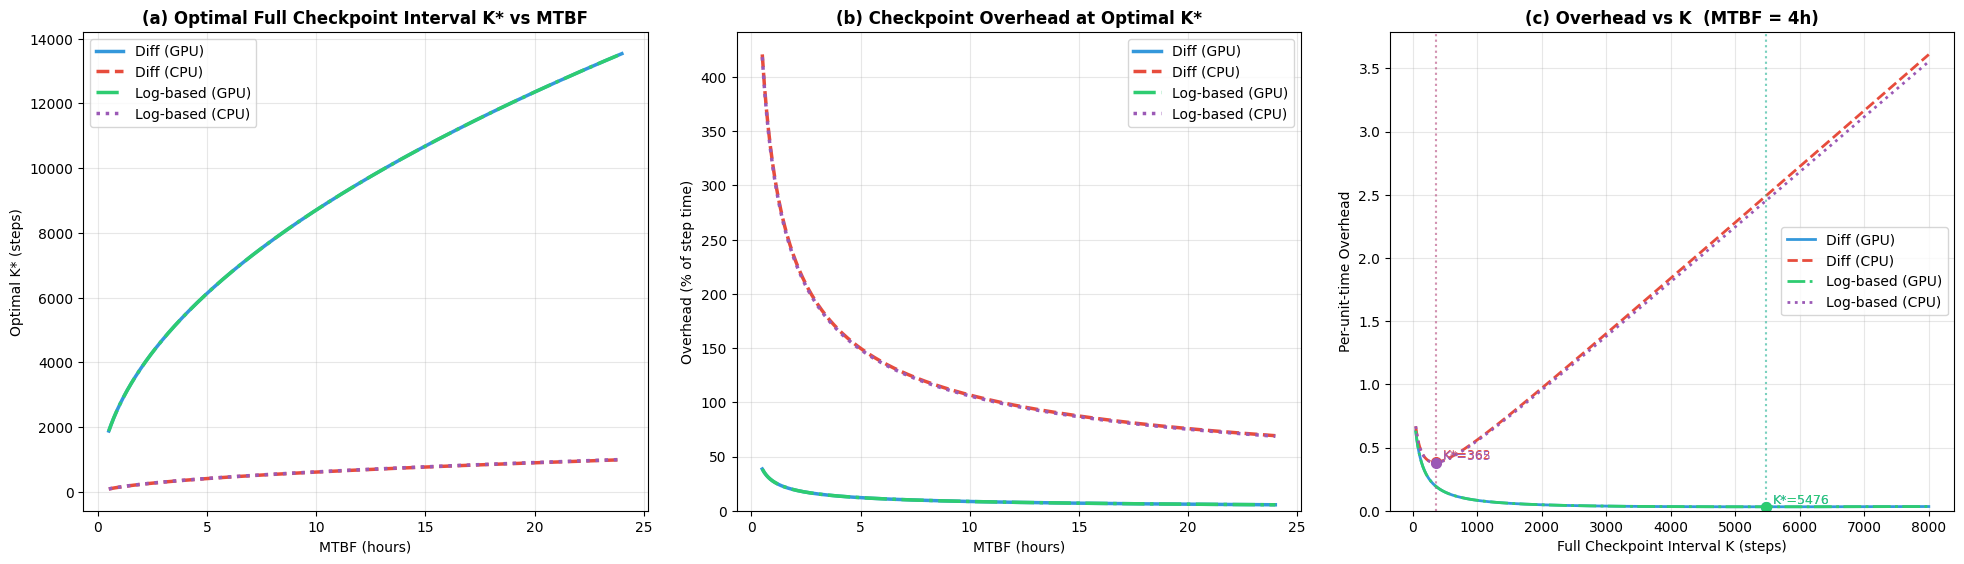

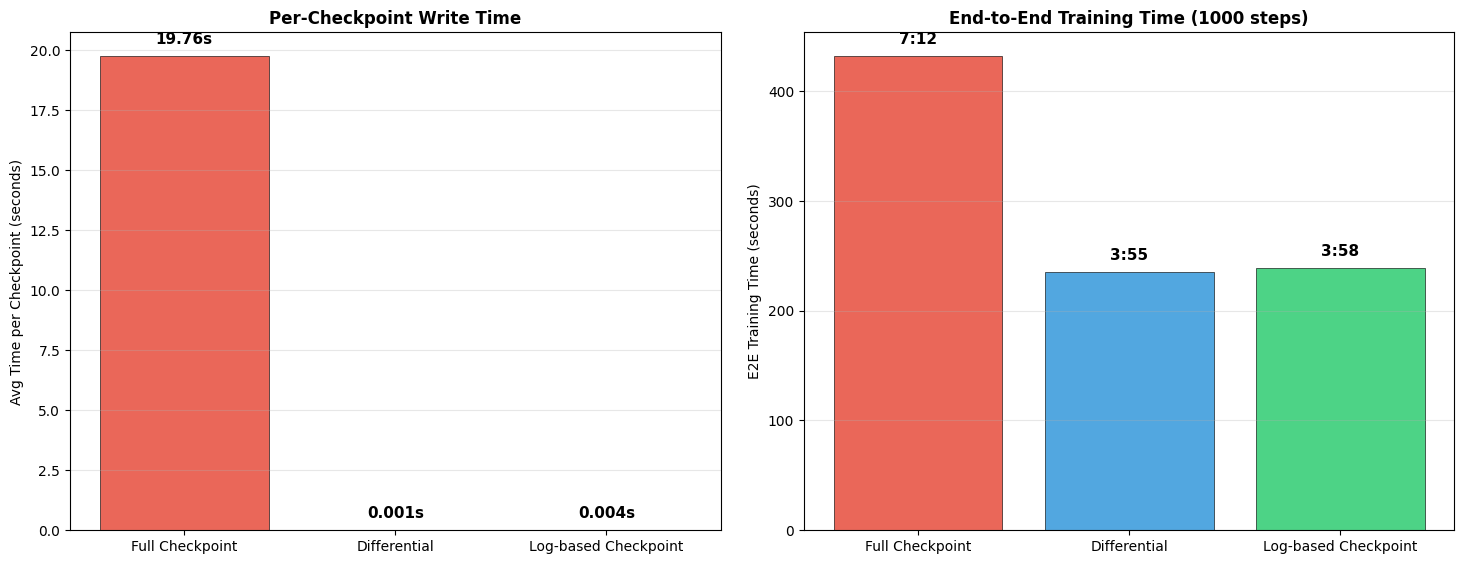

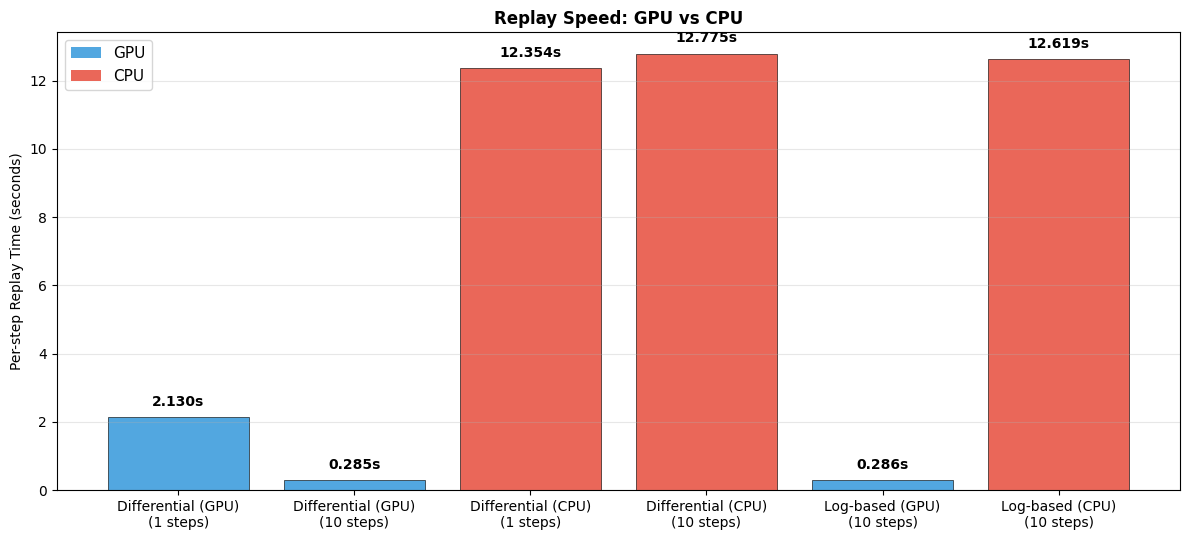

In [11]:
"""
cell.py — 在这里填入你的实验数据，然后运行
=============================================
"""

import sys
import os
import importlib
sys.path.insert(0, '/home/ubuntu/NonStopZO2/experiments')

import zo_checkpoint_model
importlib.reload(zo_checkpoint_model)
from zo_checkpoint_model import (
    print_summary,
    plot_cost_model,
    plot_strategy_comparison,
    plot_replay_speed,
)
import matplotlib.pyplot as plt

# ╔══════════════════════════════════════════════════════════════╗
# ║                    在这里填入你的数据                          ║
# ╚══════════════════════════════════════════════════════════════╝

# ---------- 基本参数 ----------
TOTAL_STEPS = 1000                    # 总训练步数

# ---------- 各 checkpoint 模式的测量结果 ----------
checkpoint_modes = [
    {
        "name": "Full Checkpoint",
        "avg_ckpt_time": 19.758,
        "total_ckpts": 10,
        "e2e_time_seconds": 432,
        "color": "#e74c3c",
    },
    {
        "name": "Differential",
        "avg_ckpt_time": 0.0009,
        "total_ckpts": 1000,
        "e2e_time_seconds": 235.32,
        "color": "#3498db",
    },
    {
        "name": "Log-based Checkpoint",
        "avg_ckpt_time": 0.0043,
        "total_ckpts": 1000,
        "e2e_time_seconds": 238.72,
        "color": "#2ecc71",
    },
]

# ---------- 恢复时间测量结果 ----------
resume_measurements = [
    {"name": "Full Checkpoint",      "load_base": 1.126, "replay_steps": 0,  "replay_time": 0,       "device": "GPU"},
    {"name": "Differential (GPU)",   "load_base": 0.628, "replay_steps": 1,  "replay_time": 2.130,   "device": "GPU"},
    {"name": "Differential (GPU)",   "load_base": 0.638, "replay_steps": 10, "replay_time": 2.846,   "device": "GPU"},
    {"name": "Differential (CPU)",   "load_base": 0.638, "replay_steps": 1,  "replay_time": 12.354,  "device": "CPU"},
    {"name": "Differential (CPU)",   "load_base": 0.640, "replay_steps": 10, "replay_time": 127.750, "device": "CPU"},
    {"name": "Log-based (GPU)",      "load_base": 0.6424,"replay_steps": 10, "replay_time": 2.8585,  "device": "GPU"},
    {"name": "Log-based (CPU)",      "load_base": 0.6449,"replay_steps": 10, "replay_time": 126.1925,"device": "CPU"},
]

# ---------- 成本模型参数 ----------
C  = 19.758         # 做一次 Full checkpoint 的时间（秒）
LOAD_BASE = 0.638   # 加载基础权重时间（秒）
STEP_TIME = 0.23    # 每步训练时间（秒），可直接填入实测值

# 4 种 replay 场景，每种有不同的 U（边际回放成本）和 cold_start
# replay_time(n) = cold_start + n * U
replay_scenarios = [
    {"name": "Diff (GPU)",      "U": 0.08,   "cold_start": 2.05,  "color": "#3498db", "ls": "-"},
    {"name": "Diff (CPU)",      "U": 12.82,  "cold_start": 0,     "color": "#e74c3c", "ls": "--"},
    {"name": "Log-based (GPU)", "U": 0.08,   "cold_start": 2.05,  "color": "#2ecc71", "ls": "-."},
    {"name": "Log-based (CPU)", "U": 12.62,  "cold_start": 0,     "color": "#9b59b6", "ls": ":"},
]

# ---------- 画图控制 ----------
MTBF_RANGE_HOURS = (0.5, 24)
MTBF_DEMO_HOURS  = 4
MTBF_TABLE_VALUES = [1, 2, 4, 8, 12, 24]

# ╔══════════════════════════════════════════════════════════════╗
# ║              以下自动运行，不需要改                              ║
# ╚══════════════════════════════════════════════════════════════╝

# 1) 打印计算结果
print_summary(C, STEP_TIME, LOAD_BASE, replay_scenarios,
              checkpoint_modes, resume_measurements,
              TOTAL_STEPS, MTBF_TABLE_VALUES)

# 2) 图1：成本模型三合一（4条线）
fig1 = plot_cost_model(C, STEP_TIME, replay_scenarios,
                       MTBF_RANGE_HOURS, MTBF_DEMO_HOURS)

# 3) 图2：各 checkpoint 策略对比柱状图
fig2 = plot_strategy_comparison(checkpoint_modes, TOTAL_STEPS)

# 4) 图3：回放速度 GPU vs CPU
fig3 = plot_replay_speed(resume_measurements)

# 显示所有图
plt.show()